<a href="https://colab.research.google.com/github/antfolk/BMEN35_2023/blob/main/Session5/BMEN35_Ex16_deep_neural_networks_assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5
## Fill in your name below
Albert Ahnlide

## Your mission is now the following:

You will use a (a modified version of a) dataset named HAM10000 ("Human Against Machine with 10000 training images")  (https://doi.org/10.7910/DVN/DBW86T). The dataset contains dermatoscopic images from different populations, acquired and stored by different modalities. The original dataset consists of 10015 dermatoscopic images, in 600x450x3 pixel resolution, which can serve as a training set for academic machine learning purposes.  Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal).

For this exercise we have downsampled the images to 100x75x3 and randomly taken 1400 samples from the original 10015 to make training times more reasonable. We have also made the dataset more balanced in terms of class distributions.

Make sure you have downloaded the `HAM1400_100_75.zip` file from Canvas to your computer.

Some tips and tricks (colab):
* Copy the dataset to google drive and copy it to the colab workspace instead of uploading it. This will save you time, if don't finish the exercise in one go.
* If you feel adventurous you can download and try some of the other resolutions and datasets (available in Canvas). There are 100x75, 256x192, 600x450 resolutions of images and the full datasets with ~10000 images and the "downsampled" datasets with 1400 images. If you use any of the other be prepared for looooong training times.
* You may also want to experiment with changing runtime in google colab (too eg GPU) and see how much faster training will be. **PLEASE NOTE THAT YOU MIGHT GET THROWN OUT OF USING GPU/TPU RUNTIMES. ONLY THE CPU RUNTIMES ARE FREE.**

We will start you off with loading the data and such and some (**maybe not all!**) of the relevant imports.

In [15]:
# Here you will upload the files
#from google.colab import files
# file = files.upload() # Choose HAM1400_100_75.zip

In [16]:
# OPTIONAL IF YOU ALREADY HAVE COPIED THE DATASET TO GOOGLE DRIVE
# This mounts your google drive
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r /content/drive/MyDrive/data/HAM1400_100_75.zip /content/


In [17]:
# # This unzips the files
# !unzip -q /content/HAM1400_100_75.zip -d /content/

Now we have the data in our workspace. Lets do some imports.


In [9]:
import os
from glob import glob
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from matplotlib import pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras.applications.inception_v3 import InceptionV3

Now we will read the data into Python.

In [5]:
# First read metadata into a dataframe
base_dir = 'HAM1400_100_75/'
skin_df=pd.read_csv(base_dir + 'dataframe.csv')
# How many rows, that is how many images are there
length = skin_df.shape[0]
# Create a dictionary for the labels
label_dict = {'nv': 0,'mel': 1,'bkl': 2, 'bcc': 3, 'akiec': 4,'vasc': 5,'df': 6 }
# Recode labels in dataframe to be numbers
skin_df['labels'] = skin_df['dx'].map(label_dict)
#Allocate space for X and y aka our data and labels
X = np.zeros((length,75,100,3))
y = np.zeros((length))
k = 0
for i in skin_df['image_id']: # Get filename from dataframe
  #print(k)
  X[k,:,:,:] = np.asarray(Image.open(base_dir +  i + '.jpg'))
  k= k+1

y = np.asarray(skin_df['labels'])


We will do the usual conversion as before.

In [6]:
# Convert data to float and scale to be between 0 and 1
X = X.astype('float32')
X /=255.0
yidx = y
y = to_categorical(y) # One-hot encode the labels
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=0)

Let's plot the data and visualise what kind of data we are dealing with.

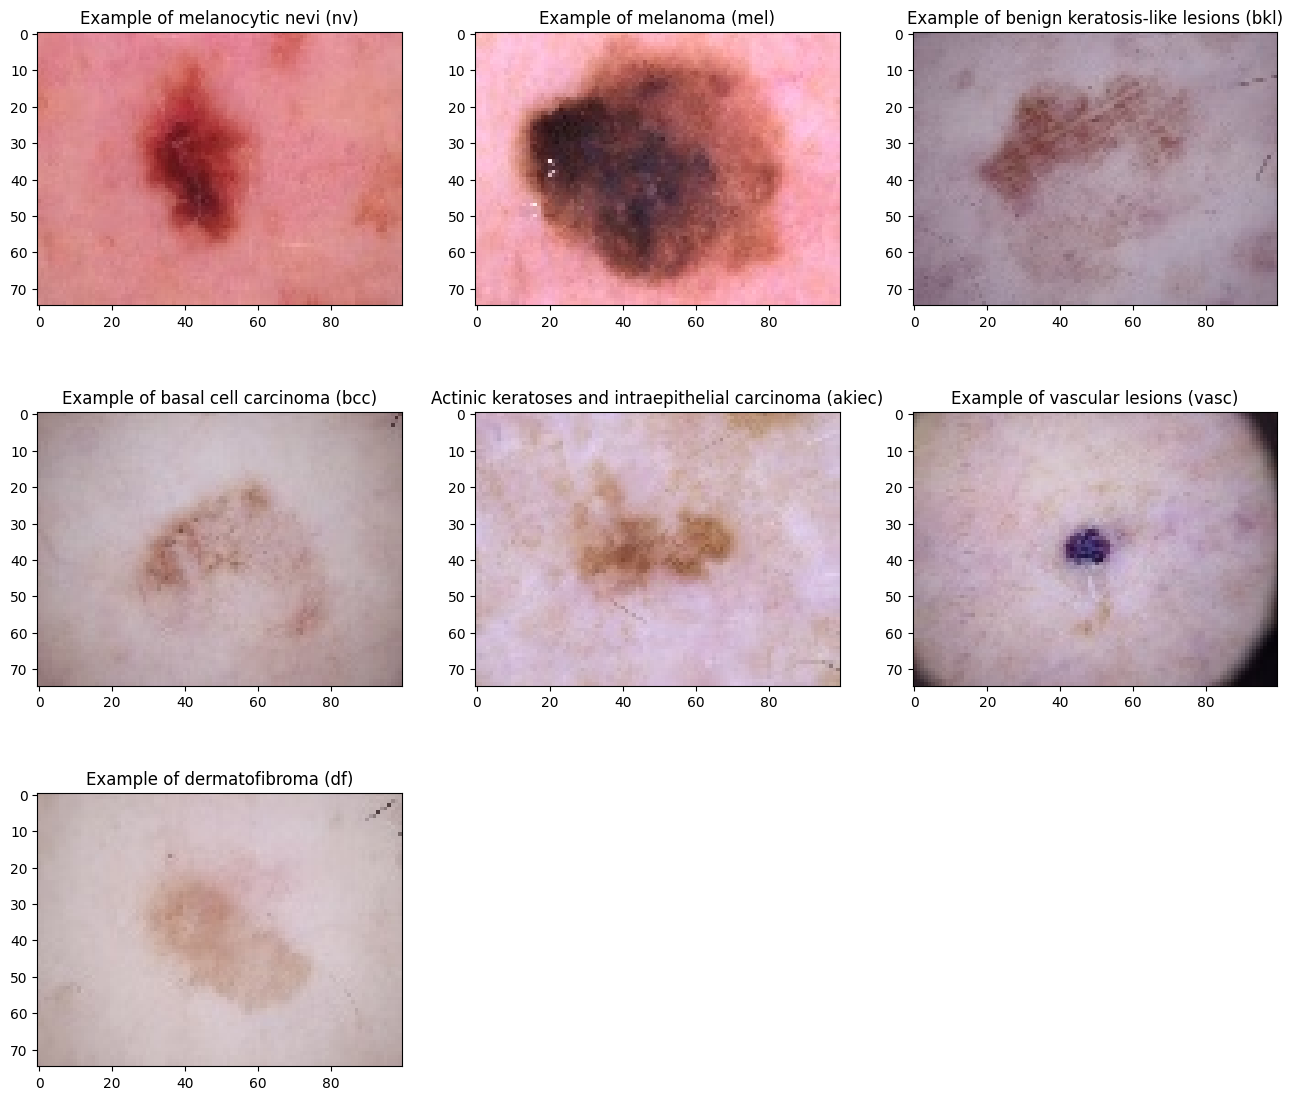

In [7]:
plt.figure(figsize=(16, 14))
plt.subplot(3, 3, 1)
plt.title('Example of melanocytic nevi (nv)')
plt.imshow(X[np.where(yidx == 0)[0][0], :, :])
plt.subplot(3, 3, 2)
plt.title('Example of melanoma (mel)')
plt.imshow(X[np.where(yidx == 1)[0][0], :, :])
plt.subplot(3, 3, 3)
plt.title('Example of benign keratosis-like lesions (bkl)')
plt.imshow(X[np.where(yidx == 2)[0][0], :, :])
plt.subplot(3, 3, 4)
plt.title('Example of basal cell carcinoma (bcc)')
plt.imshow(X[np.where(yidx == 3)[0][0], :, :])
plt.subplot(3, 3, 5)
plt.title('Actinic keratoses and intraepithelial carcinoma (akiec)')
plt.imshow(X[np.where(yidx == 4)[0][0], :, :])
plt.subplot(3, 3, 6)
plt.title('Example of vascular lesions (vasc)')
plt.imshow(X[np.where(yidx == 5)[0][0], :, :])
plt.subplot(3, 3, 7)
plt.title('Example of dermatofibroma (df)')
plt.imshow(X[np.where(yidx == 6)[0][0], :, :])
plt.show()


Now, you have data X_train, X_test and labels y_train, y_test. Create a deep learning model or (even better) use transfer learning on a pretrained model eg. Inception or any other found in eg. https://keras.io/api/applications/ ), train it properly and make predictions using it. You need get extract important metrics as well.

To be clear you need to define the model and the metrics. For example the 'classification_report' in sklearn is good way to check performance. Plotting a confusion matrix is another.

Make sure that your trained model doesn't get stuck in thinking everything is the same class.

Remember that this dataset is in color. That means your images has a "depth". Make sure you define this appropriately when you define your model. Keep in mind the number of classes/targets you have here and in what format ("one-hot encoded eg [1 0 0, 0 1 0, 0 0 1] or as "numbers" [0,1,2].

**When you have finished this assignment , save this notebook and submit it in Canvas. For the submission you only need to use the HAM1400_100_75 dataset and show the results (confusion matrix or classification report or similar, accuracy alone is not ok).**

Epoch 1/20
28/28 [==============================] - 5s 79ms/step - loss: 3.3487 - accuracy: 0.2625
Epoch 2/20
28/28 [==============================] - 2s 78ms/step - loss: 1.4718 - accuracy: 0.4607
Epoch 3/20
28/28 [==============================] - 2s 79ms/step - loss: 1.2183 - accuracy: 0.5482
Epoch 4/20
28/28 [==============================] - 2s 77ms/step - loss: 0.9765 - accuracy: 0.6464
Epoch 5/20
28/28 [==============================] - 2s 77ms/step - loss: 0.7886 - accuracy: 0.7348
Epoch 6/20
28/28 [==============================] - 2s 78ms/step - loss: 0.6418 - accuracy: 0.7830
Epoch 7/20
28/28 [==============================] - 2s 78ms/step - loss: 0.4617 - accuracy: 0.8482
Epoch 8/20
28/28 [==============================] - 2s 78ms/step - loss: 0.3365 - accuracy: 0.9062
Epoch 9/20
28/28 [==============================] - 2s 79ms/step - loss: 0.2630 - accuracy: 0.9304
Epoch 10/20
28/28 [==============================] - 2s 77ms/step - loss: 0.2118 - accuracy: 0.9384
Epoch 11/

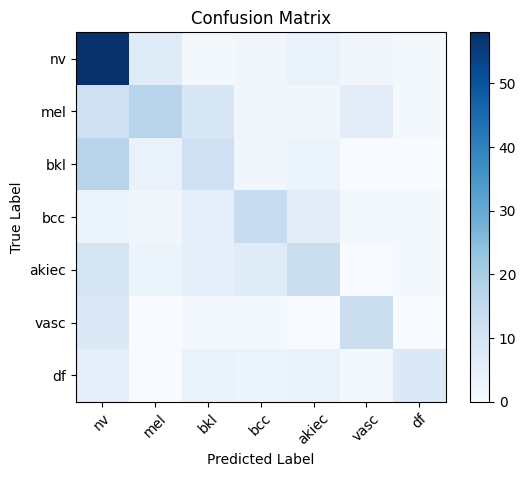

In [18]:
from sklearn import metrics


# Create the base InceptionV3 model (without the top layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 100, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


# Define class names
class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# Extend the InceptionV3 base model with custom top layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)
pred = Dense(7, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=pred)

# Compile the model with a lower learning rate and categorical crossentropy
model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

# Number of epochs
epochs = 20

# Assuming y_train and y_test are one-hot encoded
model.fit(X_train, y_train, batch_size=40, epochs=epochs)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report with class names
print(metrics.classification_report(y_true, y_pred_classes, target_names=class_names))

# Plot confusion matrix with class names
conf_matrix = metrics.confusion_matrix(y_true, y_pred_classes)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

